# Sign Detection
Can we determine the correct sign change in saturation? (1 for decrease, 0 for increase)

In [1]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from model_trainer import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN
)

from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# Load Pre-save data

In [2]:
# file_name = 'logI2_by_I1'
# file_name = 'I1_and_I2'
# file_name = 'pulsation_ratio'
file_name = "pulsation_ratio_interp_sd"
# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = DATA_PATH.with_suffix(".json")
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

In [3]:
# for label in labels:
#     print(label)
#     print(data[label].unique())
#     print("Total Length", len(data[label].unique()))

print("train data length", len(data))

train data length 515592


# Setup Training Objective

In [4]:
## Regression
y_columns = ["Fetal Saturation"]  # What to Predict

x_columns = features  # What to use as input
# x_columns = [features[i] for i in [3, 8, 12, 15, 19, 23, 28, 35, 39]] # Certain specific detectors

print("X Columns", x_columns)
print("Y Columns", y_columns)

X Columns ['10_2.0_1_/_10_2.0_2', '15_2.0_1_/_15_2.0_2', '19_2.0_1_/_19_2.0_2', '24_2.0_1_/_24_2.0_2', '28_2.0_1_/_28_2.0_2', '33_2.0_1_/_33_2.0_2', '37_2.0_1_/_37_2.0_2', '41_2.0_1_/_41_2.0_2', '46_2.0_1_/_46_2.0_2', '50_2.0_1_/_50_2.0_2', '55_2.0_1_/_55_2.0_2', '59_2.0_1_/_59_2.0_2', '64_2.0_1_/_64_2.0_2', '68_2.0_1_/_68_2.0_2', '72_2.0_1_/_72_2.0_2', '77_2.0_1_/_77_2.0_2', '81_2.0_1_/_81_2.0_2', '86_2.0_1_/_86_2.0_2', '90_2.0_1_/_90_2.0_2', '94_2.0_1_/_94_2.0_2', '10_1.0_1_/_10_1.0_2', '15_1.0_1_/_15_1.0_2', '19_1.0_1_/_19_1.0_2', '24_1.0_1_/_24_1.0_2', '28_1.0_1_/_28_1.0_2', '33_1.0_1_/_33_1.0_2', '37_1.0_1_/_37_1.0_2', '41_1.0_1_/_41_1.0_2', '46_1.0_1_/_46_1.0_2', '50_1.0_1_/_50_1.0_2', '55_1.0_1_/_55_1.0_2', '59_1.0_1_/_59_1.0_2', '64_1.0_1_/_64_1.0_2', '68_1.0_1_/_68_1.0_2', '72_1.0_1_/_72_1.0_2', '77_1.0_1_/_77_1.0_2', '81_1.0_1_/_81_1.0_2', '86_1.0_1_/_86_1.0_2', '90_1.0_1_/_90_1.0_2', '94_1.0_1_/_94_1.0_2']
Y Columns ['Fetal Saturation']


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [5]:
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Model Configuration

In [6]:
IN_FEATURES = 2 * len(x_columns)
OUT_FEATURES = 1

# These attributes stay constant between 2 points picked for change detection
change_detection_fixed_columns = [
    "Maternal Wall Thickness",
    "Maternal Hb Concentration",
    "Maternal Saturation",
    "Fetal Hb Concentration 2",
]
print("In Features :", len(x_columns))
print("Out Features:", len(y_columns))

In Features : 40
Out Features: 1


# Training Configs

In [13]:
from inverse_modelling_tfo.model_training.DataLoaderGenerators import ChangeDetectionDataLoaderGenerator
from model_trainer import ModelTrainer, TorchLossWrapper, DataLoaderGenerator, SumLoss, TorchLossWrapper
from model_trainer.ModelTrainer import ModelTrainerNoisy
from model_trainer.early_stopping import EarlyStopper
from torch.nn import BCELoss


set_seed(40)

## Validation Methods
# validation_method = RandomSplit(0.8)

all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut("Maternal Wall Thickness", all_depths[len(all_depths) // 2])  # Center value

## Define The DataLoader
dataloader_gen = ChangeDetectionDataLoaderGenerator(
    data, x_columns, y_columns[0], change_detection_fixed_columns, batch_size=32
)

## Define The Loss Function
criterion = TorchLossWrapper(BCELoss(), name="sign_detection_bce")

## Defining The Model
model = PerceptronBD([IN_FEATURES, 80, 40, 10, OUT_FEATURES])
# Attach a Sigmoid at the end of the model
model.layers.append(nn.Sigmoid())
model.model = nn.Sequential(*model.layers)

# Putting it all together
trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)

In [14]:
trainer.set_optimizer(Adam, {'lr': 1e-3, 'weight_decay': 1e-4})
trainer.set_batch_size(2048)
# trainer.set_batch_size(32)
trainer.run(100) 

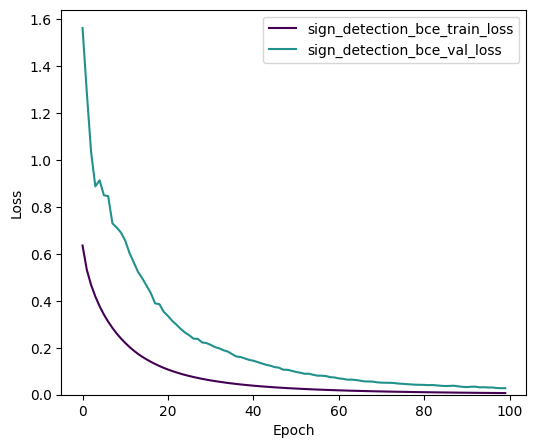

In [15]:
loss_curves = criterion.plot_losses()
plt.show()